## LSTM-VAE multi-modal anomaly detector

An unsupervised model for detecting anomaly whenever a deviation in reconstruction error is found in comparison to normal behavior. LSTM-VAE does multimodal data fusion by combining sensor feature data over time. A learnable threshold is used to decide on anomalous behavior. In the case of MHHD the sensors are Apps, Key Strokes, URLs, (and potentially Voice, Camera, Registry Keys).

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import json
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers import LSTM, RepeatVector
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.datasets import mnist

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler 
from keras.callbacks import EarlyStopping

from keras.utils import plot_model

In [2]:
nab_path = './data/NAB'
nab_data_path = nab_path + '/data/'

labels_filename = '/labels/combined_labels.json'
train_file_name = 'artificialNoAnomaly/art_daily_no_noise.csv' 
test_file_name = 'artificialWithAnomaly/art_daily_jumpsup.csv'

#train_file_name = 'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'
#test_file_name = 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

labels_file = open(nab_path + labels_filename, 'r')
labels = json.loads(labels_file.read())
labels_file.close()

def load_data_frame_with_labels(file_name):
    data_frame = pd.read_csv(nab_data_path + file_name)
    data_frame['anomaly_label'] = data_frame['timestamp'].isin(
        labels[file_name]).astype(int)
    return data_frame

train_data_frame = load_data_frame_with_labels(train_file_name)
test_data_frame = load_data_frame_with_labels(test_file_name)

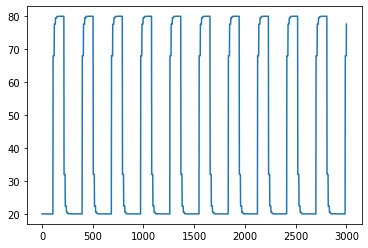

In [3]:
plt.plot(train_data_frame.loc[0:3000,'value'])

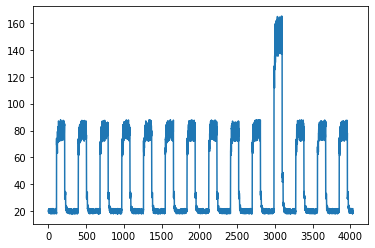

In [4]:
plt.plot(test_data_frame['value'])

In [5]:
train_data_frame_final = train_data_frame.loc[0:3000,:]
test_data_frame_final = test_data_frame

In [8]:
data_scaler = StandardScaler()
data_scaler.fit(train_data_frame_final[['value']].values)
train_data = data_scaler.transform(train_data_frame_final[['value']].values)
test_data = data_scaler.transform(test_data_frame_final[['value']].values)      

In [9]:
DATA_PATH = './data/'

def step_decay(epoch):
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 16.0
    lr_new = lr_init * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr_new

class LR_hist(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

In [10]:
def create_dataset(dataset, look_back=64):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back),:])
        dataY.append(dataset[i+look_back,:])

    return np.array(dataX), np.array(dataY)

In [11]:
X_data, y_data = create_dataset(train_data, look_back=64) #look_back = window_size
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
X_test, y_test = create_dataset(test_data, look_back=64)  #look_back = window_size

In [12]:
#training params
batch_size = 256
num_epochs = 64

#model params
timesteps = X_train.shape[1]
input_dim = X_train.shape[-1]
intermediate_dim = 16 #256
latent_dim = 2
epsilon_std = 1.0

In [14]:
#sampling layer
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [15]:
#likelihood layer
def likelihood(args):
    x, x_decoded_mean, x_decoded_scale = args
    dist = tf.contrib.distributions.MultivariateNormalDiag(x_decoded_mean, x_decoded_scale)
    likelihood = dist.log_prob(x)  
    return likelihood

In [16]:
#VAE architecture

#encoder
x = Input(shape=(timesteps, input_dim,))
h = LSTM(intermediate_dim)(x)

z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim, activation='softplus')(h)

#sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

#decoder
decoder_h = LSTM(intermediate_dim, return_sequences=True)
decoder_loc = LSTM(input_dim, return_sequences=True)
decoder_scale = LSTM(input_dim, activation='softplus', return_sequences=True)

h_decoded = RepeatVector(timesteps)(z)
h_decoded = decoder_h(h_decoded)

x_decoded_mean = decoder_loc(h_decoded)
x_decoded_scale = decoder_scale(h_decoded)

like = Lambda(likelihood, output_shape=(input_dim,))([x, x_decoded_mean, x_decoded_scale])





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability).

In [17]:
#custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
    
    def vae_loss(self, x, z_mean, z_log_sigma, likelihood):        
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = -K.mean(likelihood - kl_loss)
        return loss

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_sigma = inputs[2]
        likelihood = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_sigma, likelihood)
        self.add_loss(loss, inputs=inputs)
        return x

In [18]:
y = CustomVariationalLayer()([x, z_mean, z_log_sigma, like])
vae_like = Model(x, like)
vae = Model(x, y)

In [19]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vae.compile(loss=None, optimizer=adam, metrics=['accuracy'])
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 1)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 16)           1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            34          lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            34          lstm_1[0][0]                     
__________________________________________________________________________________________________
lambda_1 

In [20]:
#define callbacks
file_name = DATA_PATH + 'lstm-vae-weights-checkpoint.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
hist_lr = LR_hist()
reduce_lr = LearningRateScheduler(step_decay) 
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=64, verbose=1)
callbacks_list = [checkpoint, hist_lr, reduce_lr, early_stopping]

In [21]:
print("training vae model...")
hist = vae.fit(x=X_train, y=None, shuffle=True, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(X_val, None), verbose=2)

training vae model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2642 samples, validate on 294 samples
Epoch 1/64





 - 6s - loss: 1.6847 - val_loss: 1.6179

Epoch 00001: loss improved from inf to 1.68475, saving model to ./data/lstm-vae-weights-checkpoint.hdf5
Epoch 2/64
 - 1s - loss: 1.6119 - val_loss: 1.5904

Epoch 00002: loss improved from 1.68475 to 1.61188, saving model to ./data/lstm-vae-weights-checkpoint.hdf5
Epoch 3/64
 - 1s - loss: 1.5933 - val_loss: 1.5693

Epoch 00003: loss improved from 1.61188 to 1.59331, saving model to ./data/lstm-vae-weights-checkpoint.hdf5
Epoch 4/64
 - 1s - loss: 1.5739 - val_loss: 1.5477

Epoch 00004: loss improved from 1.59331 to 1.57387, saving model to ./data/lstm-vae-weights-checkpoint.hdf5
Epoch 5/64
 - 1s - loss: 1.5470 - val_loss: 1.5219

Epoch 00005: loss improved from 1.57387 to 1.54696, saving model to ./data/lstm-vae-weights-checkpoint.hdf5
Epoch 6/64
 - 1s - loss: 1.5116 -

 - 2s - loss: 1.4336 - val_loss: 1.4232

Epoch 00047: loss did not improve from 1.43273
Epoch 48/64
 - 2s - loss: 1.4341 - val_loss: 1.4146

Epoch 00048: loss did not improve from 1.43273
Epoch 49/64
 - 2s - loss: 1.4389 - val_loss: 1.4247

Epoch 00049: loss did not improve from 1.43273
Epoch 50/64
 - 2s - loss: 1.4327 - val_loss: 1.4255

Epoch 00050: loss improved from 1.43273 to 1.43271, saving model to ./data/lstm-vae-weights-checkpoint.hdf5
Epoch 51/64
 - 2s - loss: 1.4390 - val_loss: 1.4166

Epoch 00051: loss did not improve from 1.43271
Epoch 52/64
 - 2s - loss: 1.4330 - val_loss: 1.4106

Epoch 00052: loss did not improve from 1.43271
Epoch 53/64
 - 2s - loss: 1.4316 - val_loss: 1.4073

Epoch 00053: loss improved from 1.43271 to 1.43164, saving model to ./data/lstm-vae-weights-checkpoint.hdf5
Epoch 54/64
 - 2s - loss: 1.4371 - val_loss: 1.4200

Epoch 00054: loss did not improve from 1.43164
Epoch 55/64
 - 2s - loss: 1.4282 - val_loss: 1.3982

Epoch 00055: loss improved from 1.431

In [ ]:
vae.save(DATA_PATH + 'lstm-vae-final_model.h5', overwrite=True)
vae.save_weights(DATA_PATH + 'lstm-vae-final_weights.h5', overwrite=True)

In [ ]:
#load saved model
#vae = load_model(DATA_PATH + 'final_model.h5')

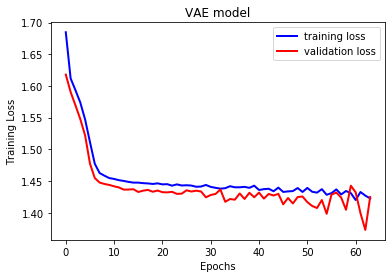

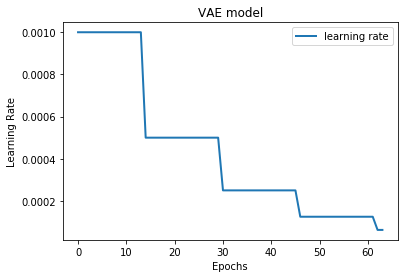

In [22]:
#generate plots

plt.figure()
plt.plot(hist.history['loss'], lw=2.0, c='b', label='training loss')
plt.plot(hist.history['val_loss'], lw=2.0, c='r', label='validation loss')
plt.title('VAE model')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig('./figures/lstm_vae_training_loss.png')


plt.figure()
plt.plot(hist_lr.lr, lw=2.0, label='learning rate')
plt.title('VAE model')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.savefig('./figures/lstm_vae_learning_rate.png')

In [24]:
pred_test = vae_like.predict(X_test)

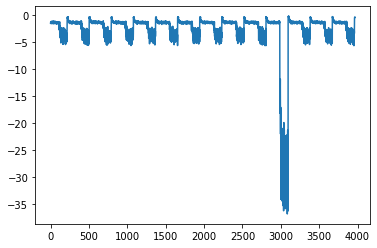

In [31]:
plt.plot(pred_test[:,0])

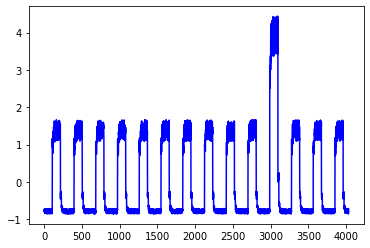

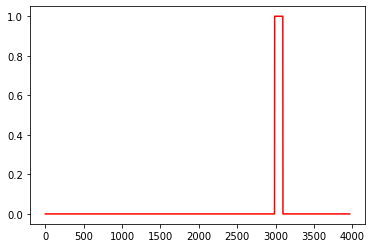

In [35]:
is_anomaly = pred_test[:,0] < -1e1
plt.figure()
plt.plot(test_data, color='b')
plt.figure()
plt.plot(is_anomaly, color='r')

## References

[1] Park et al., "A Multimodal Anomaly Detector for Robot-Assisted Feeding Using an LSTM-Based Variational Autoencoder", arXiv 2018: https://arxiv.org/pdf/1711.00614.pdf  
[2] Zhang et al, "Time Series Anomaly Detection with Variational Autoencoders": https://arxiv.org/pdf/1907.01702.pdf  
[3] An et al, "Variational Autoencoder based Anomaly Detection using Reconstruction Probability": http://dm.snu.ac.kr/static/docs/TR/SNUDM-TR-2015-03.pdf  |